# Base

In [1]:
import math
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def draw_basemap(ax, extent=None, gridline=None, show_gridline = None, ocean=False, river=True):
    
    crs = ax.projection

    if extent: # border of map
        ax.set_extent(extent, crs=crs)

    ax.coastlines(zorder=3) #draw coastline

    if river:
        ax.add_feature(cfeature.LAKES)
        ax.add_feature(cfeature.RIVERS)

    if ocean:
        ax.add_feature(cfeature.OCEAN)

    if gridline: # interval of lat&lon
        x0, x1, y0, y1 = extent
        if show_gridline:
            ax.gridlines(ylocs=range(-90, 91, gridline), xlocs=range(-180, 181, gridline))
        x0 = math.ceil(x0 // gridline) * gridline
        x1 = math.floor(x1 // gridline) * gridline
        y0 = math.ceil(y0 // gridline) * gridline
        y1 = math.floor(y1 // gridline) * gridline
        ax.set_xticks(range(x0, x1+1, gridline), crs=crs)
        ax.set_yticks(range(y0, y1+1, gridline), crs=crs)

        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        
        ax.tick_params(labelsize=9) # 设置tick lable为9磅

# Demo-0

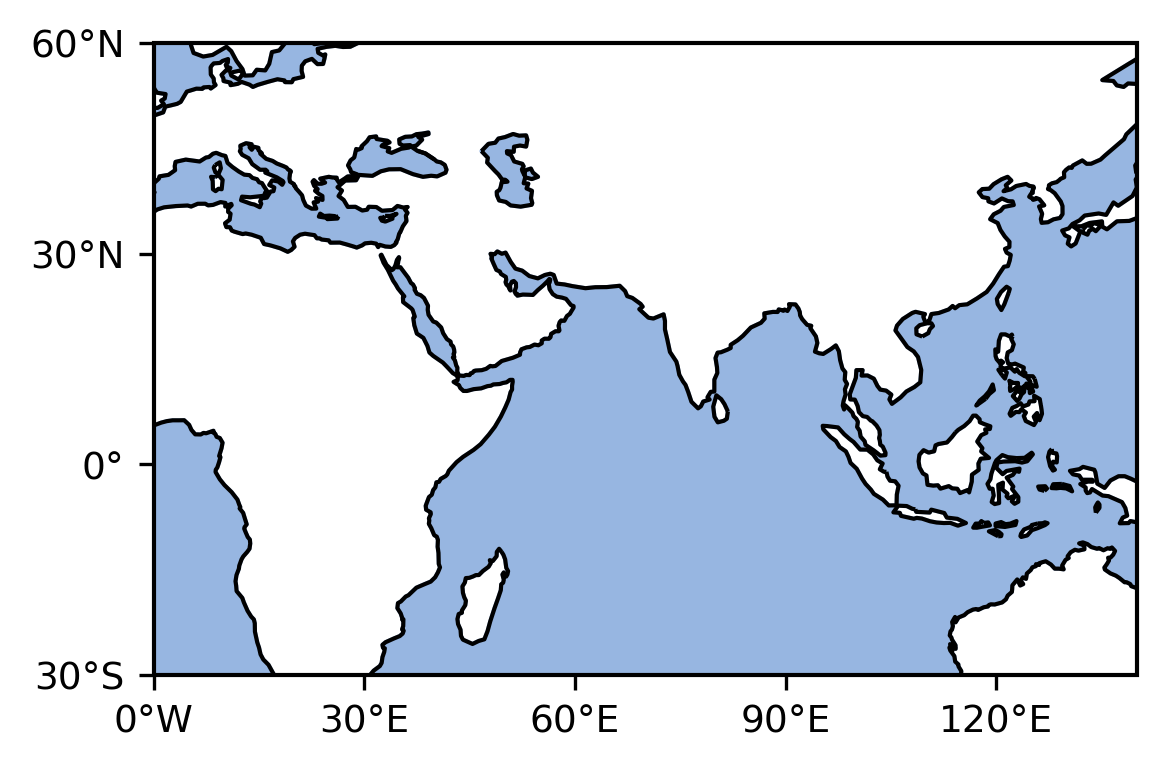

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

extent = [0, 140, -20, 60]

crs = ccrs.PlateCarree() # 调用cartopy

# 设置画布大小和分辨率
plt.figure(figsize=(4, 3), dpi=300) # 宽4英寸，高3英寸，300dpi分辨率，dpi表示1英寸中的像素数

ax = plt.axes(projection=crs)

draw_basemap(ax, extent, gridline = 30, river=False, ocean=True)

plt.tight_layout()
plt.show()

保存图片

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

extent = [0, 140, -20, 60]

crs = ccrs.PlateCarree()

for dpi in (100, 300):
    # 设置画布大小和分辨率
    plt.figure(figsize=(4, 3), dpi=dpi) # 宽4英寸，高3英寸，300dpi分辨率，dpi表示1英寸中的像素数

    ax = plt.axes(projection=crs)

    draw_basemap(ax, extent, 30, river=False, ocean=True)

    plt.tight_layout()
    #plt.show()
    plt.savefig('Demo-0-%ddpi'%dpi) # plt.show()之后plt将被清空，所以如果想通过plt.savefig()保存图片，不要plt.show()
    plt.close()

# Line

读取shape文件中的三维迹线

In [6]:
import shapefile

class Trajectorys(object):

    def __init__(self, xyzq):
        self.xyzq = xyzq  # batch x tsize x 4
        self.size = xyzq.shape[0]
        
def load_from_shp(filename):
    
    with shapefile.Reader(filename) as shp:
        assert shp.shapeType == shapefile.POLYLINEZ # 判断shape类型是否为POLYLINEZ
        count, max_tsize = len(shp), len(shp.shape(0).z)

        xyzq = np.zeros((count, max_tsize, 4), dtype='float64')
        
        for i in range(count):
            shprec = shp.shapeRecord(i)
            xyzq[i, :, 2] = shprec.shape.z
            xyzq[i, :, 3] = shprec.shape.m
            xyzq[i, :, 1::-1] = shprec.shape.points
        
        return Trajectorys(xyzq)

给迹线附色

In [7]:
import matplotlib.colors
from matplotlib.collections import LineCollection

def make_segments(xy):
    points = xy.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def draw_trajs_humidity(ax, trajs, lw=0.1, cmap = 'gnuplot_r', vmin=None, vmax=None, **styles):
    
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    mapable = None
    
    for tid in range(trajs.size):
        xyzq = trajs.xyzq[tid]
        z = xyzq[:, 3] * 1000
        segments = make_segments(xyzq[:, 1::-1])
        mapable = LineCollection(segments, array=z, transform=ax.projection, cmap=cmap, norm=norm, lw=lw, **styles)
        ax.add_collection(mapable)
        
    return mapable

# Demo-1

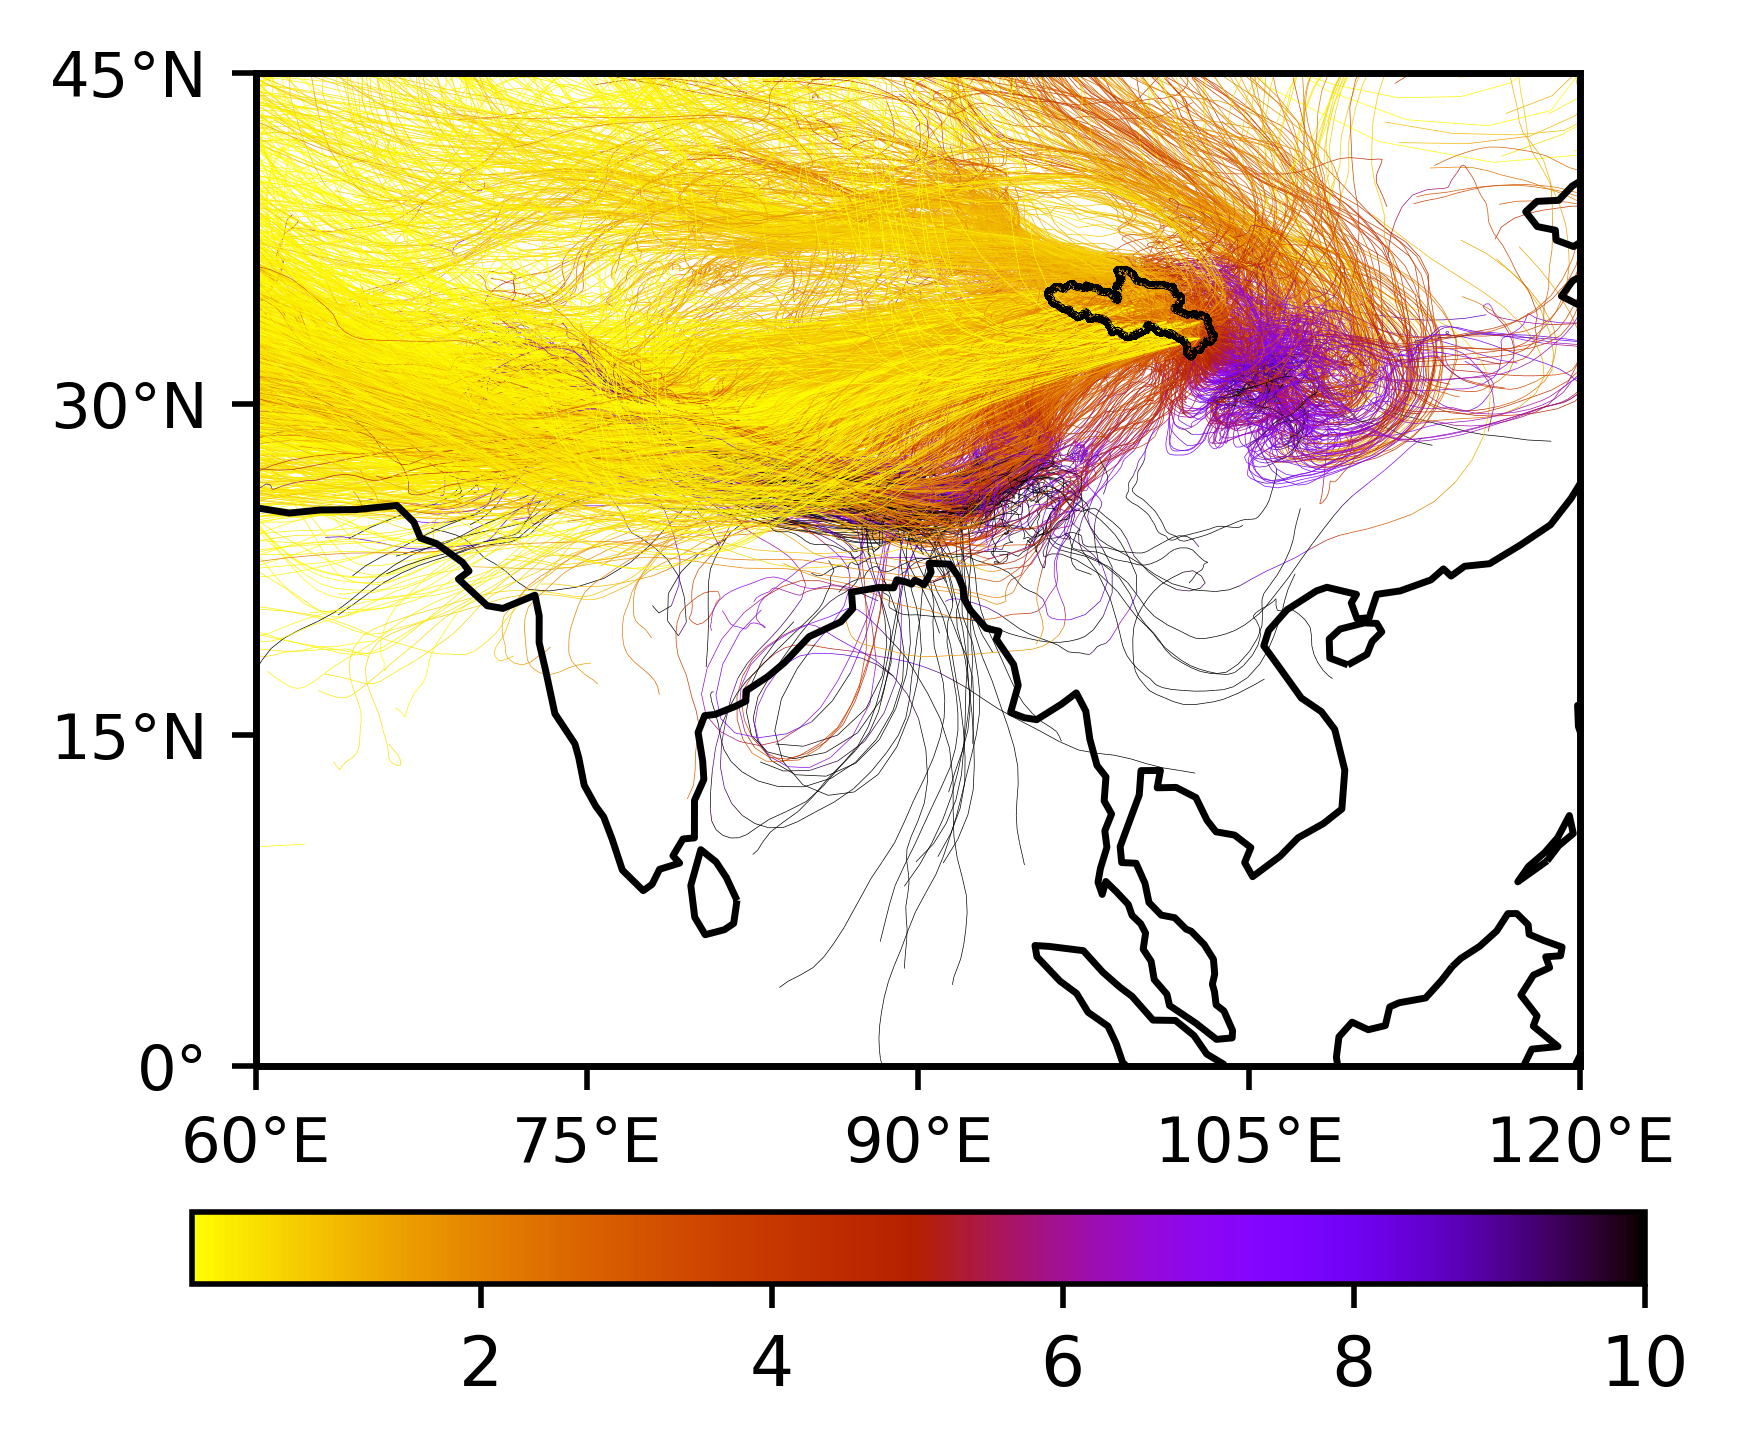

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

extent = [60, 120, 0, 45]

crs = ccrs.PlateCarree()

# 设置画布大小和分辨率
plt.figure(figsize=(4, 3), dpi=500)

ax = plt.axes(projection=crs)

#绘制底图
draw_basemap(ax, extent, 15, river=False)

#绘制迹线
trajs = load_from_shp('201810-traj')
lc = draw_trajs_humidity(ax, trajs, cmap = 'gnuplot_r', vmax = 10)
#绘制迹线的colorbar
clb = plt.colorbar(lc, orientation="horizontal", fraction=0.06, pad=0.12) # 相对画布
plt.tick_params(labelsize=9)

#绘制研究区域边界
bound = shpreader.Reader('hhy.shp').geometries()
ax.add_geometries(bound, ax.projection, edgecolor='black', facecolor='none', linewidth=1, zorder = 3)

plt.tight_layout()
plt.show()
#plt.savefig('Demo-1')
plt.close()

# Contourf

In [9]:
def draw_ee(ax, amap, lats, lons, intervals=None, cmap=None):
    
    crs = ax.projection
    cf = plt.contourf(lons, lats, amap, transform=crs, cmap=cmap, extend='max', levels=intervals)
    cf.collections[0].set_alpha(0)
    cf.collections[1].set_alpha(0.5)
    
    return cf

# Demo-2

In [10]:
import numpy

ee = np.load('EE_201810.npy') # data是一个二维矩阵
print(ee.shape)

(241, 480)


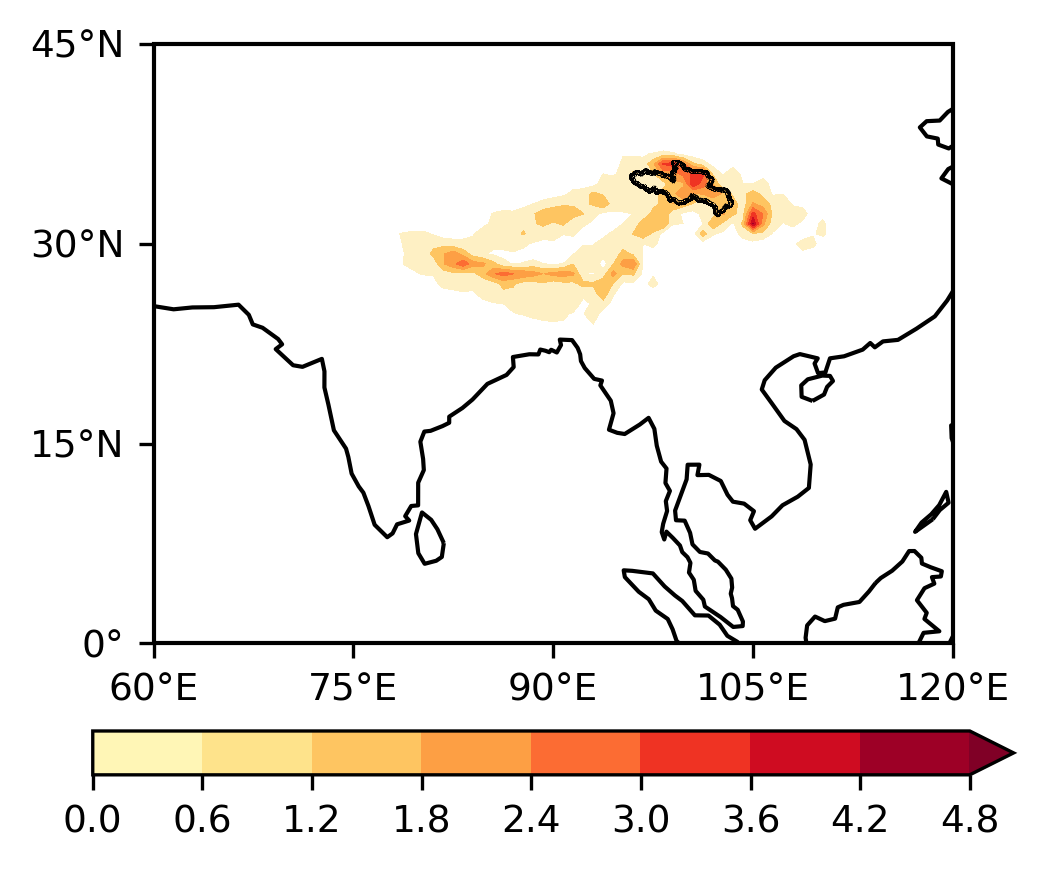

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

extent = [60, 120, 0, 45]

crs = ccrs.PlateCarree()

# 设置画布大小和分辨率
plt.figure(figsize=(4, 3), dpi=300)

ax = plt.axes(projection=crs)

#绘制底图
draw_basemap(ax, extent, 15, river=False)

lats = np.arange(90, -90.75, -0.75)
lons = np.arange(0, 360, 0.75)

#绘制contourf
cf = draw_ee(ax, ee, lats, lons,  cmap='YlOrRd')

#绘制colorbar
clb = plt.colorbar(orientation="horizontal", fraction=0.06, pad=0.12)
clb.ax.tick_params(labelsize=9)

#绘制研究区域边界
bound = shpreader.Reader('hhy.shp').geometries()
ax.add_geometries(bound, ax.projection, edgecolor='black', facecolor='none', linewidth=1, zorder = 3)

plt.tight_layout()
plt.show()
#plt.savefig('Demo-2')
plt.close()